# Intro

This notebook is in regards to analyzing the airbnb data from 29 February 2021.  This is part of an open-ended assignment.  In order to investigate the data, a scenario has been invented, and analysis will be carried out with respect to this scenario.

# Scenario
A new small business has opened up in London that will recommend asking prices to individuals who have never rented before.  The business will target individuals who seek to rent:
* Entire home/apt
* price < 1000

## Constraints

* Limited time:
* * It is more important for me to come up with some model at all than come up with the best model.

* Data-set:
* * The basic data set (listings) is mid-sized (~75000 entries).  The count of those that fit the scenario is: 41347
* * The feature space is essentially infinite (more on features below)
* * If the feature space can be simplified, more complex models may be trainable

* Domain knowledge:
* * I've never used airbnb
* * I have traveled as a tourist and for business

## Initial Analysis

A brief initial analysis has been conducted.  I've looked at the columns in the dataset, and the variables I intend to use for the model are:
* latitude
* longitude
* bedrooms - float
* bathrooms_text - str (will tranform to float)
* description - str (see below)
* amenities - str (see below)
* host_about (see below)

Essentially, this is a regression task that will require some amount of NLP in order to reduce the feature space.  In particular, reasonable categories need to be determined for *description*, *amenities*, and *host_about*.

In [131]:
# imports
from collections import defaultdict
from pprint import pprint
import re
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

plt.rcParams['figure.figsize'] = (10,10)

In [12]:
# Initialization

# loading data
_listings = pd.read_csv('data/listings.csv')
# convert prices to float
_listings['price_float'] = _listings.price.replace(r'\$|\.00|,','',regex=True).astype(float)
# restricting to relevant data
required_columns = [
    'room_type',
    'latitude',
    'longitude',
    'bedrooms',
    'bathrooms_text',
    'description',
    'amenities',
    'host_about',
    'price_float',
]
listings = _listings[required_columns]
listings = listings[(listings.room_type == 'Entire home/apt') & (listings.price_float < 1000)]
listings.count()

room_type         41347
latitude          41347
longitude         41347
bedrooms          37822
bathrooms_text    41323
description       40174
amenities         41347
host_about        24360
price_float       41347
dtype: int64

## Amenities
First, I'll analyze the amenities.

In [14]:
listings.amenities.iloc[0]

'["Refrigerator", "Shampoo", "Long term stays allowed", "Hangers", "Hot water", "Kitchen", "Wifi", "Washer", "Essentials", "Hair dryer", "Smoke alarm", "Heating", "Dishes and silverware", "TV", "Dryer", "Iron", "Cooking basics", "Air conditioning", "Dedicated workspace", "Luggage dropoff allowed", "Coffee maker", "Cable TV", "Fire extinguisher", "Microwave"]'

So, it appears that the amenities are given as strings, which are in turn stringified python arrays.
In order to work with the data, first I'll get a list of lists of amenities.

In [19]:
amenities = []
for amenity_str in listings.amenities:
    exec(f'amenities.append({amenity_str})', globals())
assert len(amenities) == listings.amenities.count()
assert type(amenities[0]) == list
assert type(amenities[0][0]) == str

Next, I'd like to take a look at all the unique amenities listed, and a count of how often the appear.

In [21]:
amenity_count = defaultdict(int)
for amenity_list in amenities:
    for amenity in amenity_list:
        amenity_count[amenity] += 1
pprint(amenity_count)

defaultdict(<class 'int'>,
            {'16" TV with standard cable': 1,
             '17" TV': 1,
             '19" HDTV with Netflix, premium cable, Roku': 1,
             '28" HDTV': 1,
             '28" TV with standard cable': 1,
             '30" TV': 2,
             '32" HDTV': 3,
             '32" HDTV with Chromecast': 1,
             '32" HDTV with Chromecast, standard cable': 1,
             '32" HDTV with Netflix': 3,
             '32" HDTV with Netflix, Amazon Prime Video': 2,
             '32" HDTV with standard cable': 1,
             '32" TV': 3,
             '32" TV with Netflix': 1,
             '32" TV with standard cable': 4,
             '35" HDTV with Netflix, HBO Max': 1,
             '37" HDTV with Amazon Prime Video, Netflix': 1,
             '38" HDTV with Amazon Prime Video, Netflix, standard cable, Apple TV': 1,
             '39" TV': 1,
             '40" HDTV': 3,
             '40" TV': 1,
             '40" TV with Netflix': 1,
             '42" HDTV with p

             'Washer': 37824,
             'Washer –\xa0In building': 23,
             'Washer –\xa0In unit': 115,
             'Waterfront': 390,
             'White Company  body soap': 1,
             'White Company  conditioner': 1,
             'Wifi': 39282,
             'Wifi – 1 Mbps': 1,
             'Wifi – 100 Mbps': 12,
             'Wifi – 1000 Mbps': 1,
             'Wifi – 110 Mbps': 2,
             'Wifi – 140 Mbps': 2,
             'Wifi – 15 Mbps': 1,
             'Wifi – 150 Mbps': 1,
             'Wifi – 200 Mbps': 2,
             'Wifi – 213 Mbps': 1,
             'Wifi – 250 Mbps': 1,
             'Wifi – 3 Mbps': 1,
             'Wifi – 30 Mbps': 4,
             'Wifi – 35 Mbps': 3,
             'Wifi – 36 Mbps': 1,
             'Wifi – 380 Mbps': 1,
             'Wifi – 40 Mbps': 3,
             'Wifi – 45 Mbps': 3,
             'Wifi – 5 Mbps': 1,
             'Wifi – 50 Mbps': 10,
             'Wifi – 500 Mbps': 1,
             'Wifi – 54 Mbps': 1,
           

It appears that most amenities only appear once, while there are some amenities that appear 100s of times, and some that appear 10000s of times.  A histogram of the counts may be nice to see this.

(array([543.,  11.,   4.,   6.,   1.,   2.,   3.,   0.,   3.,   2.,   3.,
          0.,   2.,   1.,   1.,   1.,   3.,   1.,   2.,   4.]),
 array([1.00000e+00, 2.00990e+03, 4.01880e+03, 6.02770e+03, 8.03660e+03,
        1.00455e+04, 1.20544e+04, 1.40633e+04, 1.60722e+04, 1.80811e+04,
        2.00900e+04, 2.20989e+04, 2.41078e+04, 2.61167e+04, 2.81256e+04,
        3.01345e+04, 3.21434e+04, 3.41523e+04, 3.61612e+04, 3.81701e+04,
        4.01790e+04]),
 <BarContainer object of 20 artists>)

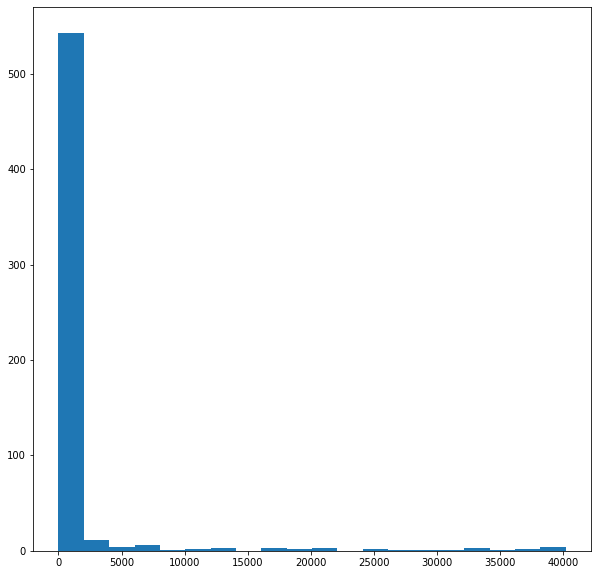

In [105]:
plt.hist(amenity_count.values(), bins=20)

The histogram supports my initial impression.  Upon looking at the actual amenities and their counts, it seems that much of the disparity occurs due to specificity.  For example:
* 'Refrigerator' occurs 20991 times, but 'Samsung refrigerator' occurs once; 
* 'Shampoo' occurs 29172 times, but 'L'Oreal or Seak Kelp (Sustainable) by Scottish Fine Soaps shampoo' occurs once.
I would suppose that the fact that a unit has a 'Samsung refrigerator' vs just 'Refrigerator' most likely won't effect what a reasonable price for renting the unit would be, but more importantly due to the constraints above it is a reasonable way to reduce the feature space.

### Amenity Categories
I suppose that most users of airbnb can roughly be broken up into three categories:
* tourist
* businessman
* host

So, I try to imagine what each renter may be interested in when looking up a unit on airbnb.
* tourist: toiletries, wifi, transportation
* businessman: parking, laundry, wifi, staff, workspace, gym
* host: kitchen, entertainment, party_space (e.g. balcony)

These seem like reasonable categories, and are at least a good start.  I need some functions to map amenity lists to boolean for these categories.  A simple idea would be a test like: "if the word 'soap' appears in the list of amenities, then regard the unit as having toiletries."  To get a good idea of how to implement this heuristic, I'll map all words that appear in the amenity lists to the number of times they appear, and I'll use the most commonly appearing words as tests for the categories.

In [31]:
amenity_word_count = defaultdict(int)
for amenity, count in amenity_count.items():
    for word in re.split(r'\W', amenity.lower()):
        amenity_word_count[word] += count
pprint(sorted(amenity_word_count.items(), key=lambda t: t[1], reverse=True))

[('alarm', 61613),
 ('dryer', 52233),
 ('allowed', 41501),
 ('tv', 41347),
 ('kitchen', 40466),
 ('wifi', 39866),
 ('heating', 39764),
 ('essentials', 39298),
 ('washer', 38017),
 ('smoke', 36343),
 ('long', 35698),
 ('term', 35698),
 ('stays', 35698),
 ('iron', 33990),
 ('hangers', 33613),
 ('and', 30713),
 ('hair', 30681),
 ('shampoo', 29187),
 ('dedicated', 27790),
 ('workspace', 27790),
 ('hot', 27198),
 ('water', 25890),
 ('carbon', 25270),
 ('monoxide', 25270),
 ('refrigerator', 21052),
 ('dishes', 20935),
 ('silverware', 20935),
 ('oven', 19506),
 ('cooking', 19150),
 ('basics', 19150),
 ('parking', 18537),
 ('stove', 17899),
 ('bed', 17323),
 ('linens', 17323),
 ('microwave', 17297),
 ('premises', 14882),
 ('private', 14080),
 ('entrance', 14059),
 ('dishwasher', 13519),
 ('or', 13389),
 ('fire', 13140),
 ('extinguisher', 13133),
 ('coffee', 11417),
 ('first', 11391),
 ('aid', 11391),
 ('kit', 11391),
 ('maker', 11354),
 ('free', 10737),
 ('elevator', 9493),
 ('on', 8683),
 ('p

In [29]:
len(amenity_word_count)

556

Since there are only 556 words appearing in this list, I'll just go through it and come up with the keywords related to the categories, and I'll define the tests later.  Roughly speaking, words that hardly appear at all won't be good features for our simple model, but words that occur too often don't give enough information.  Here's my list:

* toiletries: shampoo, soap, 
* wifi: wifi
* transportation
* parking: parking
* laundry: iron, hangers, laundromat
* staff: staff
* workspace: workspace, desk
* gym: gym
* kitchen: refrigerator, fridge, dishes, stove, oven,
* entertainment: tv, cable, game, sound, hdtv
* party_space: garden, backyard, pool, bbq, grill, barbeque, lake, beach

It looks like I didn't come up with a good keyword for transportation, so I'll leave it out.  'staff' only occurs 925 times, so I'll prune that feature as well.  For the rest of the features, we'll just test if any one of the related keywords appears in the amenities string.

In [32]:
amenity_keywords = {
    'toiletries': ['shampoo', 'soap'],
    'wifi': ['wifi'],
    'parking': ['parking'],
    'laundry': ['iron','hangers','laundromat'],
    'workspace': ['workspace', 'desk'],
    'gym': 'gym',
    'kitchen': ['refrigerator', 'fridge', 'dishes', 'stove', 'oven'],
    'entertainment': ['tv', 'cable', 'game', 'sound', 'hdtv'],
    'party_space': ['garden', 'backyard', 'pool', 'bbq', 'grill', 'barbeque', 'lake', 'beach'],
}

I'll make a utility function that takes a dataframe, a column name, and a list of keywords, and returns a series which represents the value of the feature`

In [34]:
def map_keyword_to_feature(df, col, keywords):
    def contains_mask(kw):
        return df[col].str.lower().str.contains(kw)
    def reducer(acc, kw):
        return acc | contains_mask(kw)
    return reduce(reducer, keywords[1:], contains_mask(keywords[0])).astype(float)

In [37]:
amenity_features = {
    k: map_keyword_to_feature(listings, 'amenities', v) for k,v in amenity_keywords.items()
}

A quick bar chart for a sanity check on the features.

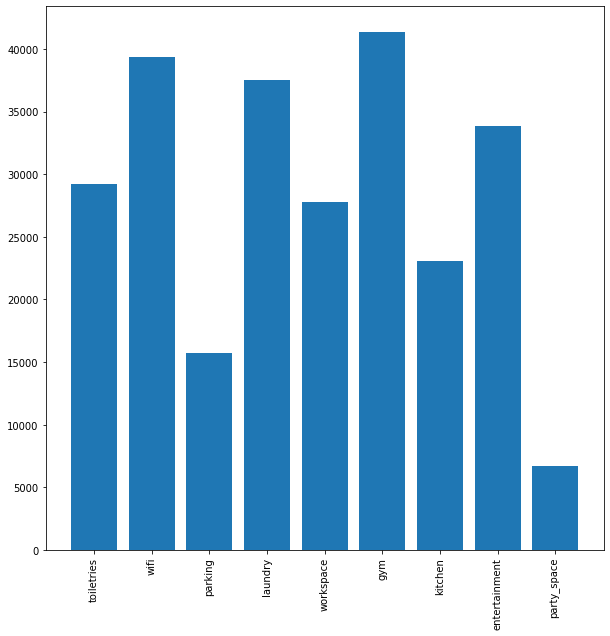

In [82]:
def bar_plot_features(features):
    heights = [v.sum() for v in features.values()]
    ticks = range(len(features))
    plt.bar(ticks, heights)
    plt.xticks(ticks, labels=features.keys(), rotation=90)

bar_plot_features(amenity_features)

## description
My first idea is to consider words that appear in the descriptions of the most expensive and least expensive units.  It seems like these could be good features.  Also, considering our potential renters (tourists, businessmen, and hosts), I think the following may be good keyword-lists:
* tourist: tourist, visit
* businessman: professional, business, company
* host: party, fun, view

I'll read a couple descriptions, and see if these keywords still seem reasonable.

In [56]:
descriptions = [listings.iloc[i].description for i in range(0,2000,100)]
pprint(list(enumerate(descriptions)))

[(0,
  "Lots of windows and light.  St Luke's Gardens are at the end of the block, "
  'and the river not too far the other way. Ten minutes walk if you go slowly. '
  'Buses to everywhere round the corner and shops, restaurants, pubs, the '
  'cinema and Waitrose .<br /><br /><b>The space</b><br />Bright Chelsea '
  'Apartment <br /><br />This is a bright one bedroom ground floor apartment '
  'in an interesting listed building. There is one double bedroom and a living '
  'room/kitchen The apartment has a full <br />bathroom and the kitchen is '
  'fully equipped. Two wardrobes are available exclusively for guests and '
  'bedside tables and two long drawers.<br /><br />This sunny convenient '
  'compact flat is just around the corner from the Waitrose supermarket and '
  'all sorts of shops, cinemas, restaurants and pubs.  This is a lovely part '
  "of London.<br /><br />There is a fun farmers market in the King's Road at "
  'the weekend. <br /><br />Buses to everywhere are just ro

After reading these reviews, I'll update my lists

* tourist: tourist, visit, bus, cool, charm, memorable, pub, bar, cafe
* businessman: professional, business, company, airport, safe, heathrow, private
* host: party, fun, view, dine, cosy, terrace, modern

Now I'll check out the words that appear in the descriptions of the most expensive vs the least expensive units.

In [65]:
cheap_listings = listings[listings.price_float <= listings.price_float.quantile(.25)]
expensive_listings = listings[listings.price_float >= listings.price_float.quantile(.75)]

def get_word_counts(df, col):
    word_counts = defaultdict(int)
    for text in df[col]:
        # some of the entries are null
        if type(text) != str:
            continue
        for word in re.split(r'\W', text):
            # this will help to not count too much "garbage"
            if not re.match(r'[a-zA-Z]+$', word):
                continue
            word_counts[word.lower()] += 1
    return word_counts

cheap_word_counts = get_word_counts(cheap_listings, 'description')
expensive_word_counts = get_word_counts(expensive_listings, 'description')


To try to get some interesting data from these word counts, we'll only consider words that:
* occur at least 5 times
* occur less than 1/2 df.count() times
This serves multiple purposes, such as stopword removal, and removing words that are too rare to be a useful feature.

Then, we'll look at words that appear in the symettric difference of the sets of words.b

In [76]:
cheap_words = set([k for k,v in cheap_word_counts.items() if v >= 5 and v <= cheap_listings.description.count()/2])
expensive_words = set([k for k,v in expensive_word_counts.items() if v >= 5 and v <= expensive_listings.description.count()/2])

In [93]:
only_cheap_words = cheap_words - expensive_words
only_expensive_words = expensive_words - cheap_words

pprint([len(only_cheap_words), list(only_cheap_words)[:5], len(only_expensive_words), list(only_expensive_words)[:5]])

[912,
 ['ritzy', 'addington', 'warner', 'stairway', 'govt'],
 1352,
 ['inspires', 'conquer', 'doorsteps', 'wunderkinds', 'kens']]


So at this point we can extract five more features from the listings.
**NOTE**
Trying to compute them is taking too long, because the implemenation is not very efficient at this point, and the 'only...words' are too large.  Here we'll take a shortcut and make a very unprincipled optimization...

In [95]:
N_WORDS_OPT = 20
only_cheap_words = list(only_cheap_words)[:N_WORDS_OPT]
only_expensive_words = list(only_expensive_words)[:N_WORDS_OPT]

# pprint([only_cheap_words, only_expensive_words])

In [96]:
description_keywords = {
    'tourist': ['tourist', 'visit', 'bus', 'cool', 'charm', 'memorable', 'pub', 'bar', 'cafe'],
    'businessman': ['professional', 'business', 'company', 'airport', 'safe', 'heathrow', 'private'],
    'host': ['party', 'fun', 'view', 'dine', 'cosy', 'terrace', 'modern'],
    'only_cheap_words': list(only_cheap_words),
    'only_expensive_words': list(only_expensive_words),
}

description_features = {
    k: map_keyword_to_feature(listings, 'description', v) for k,v in description_keywords.items()
}

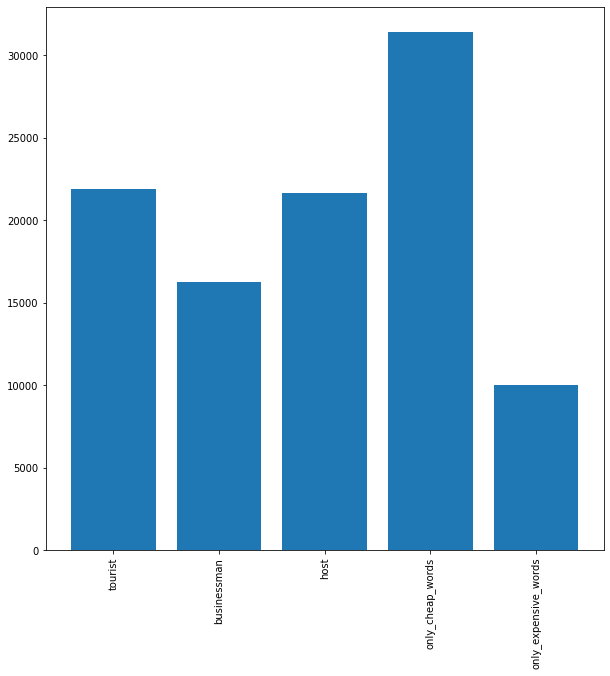

In [103]:
bar_plot_features(description_features)

In [104]:
print([description_features['only_cheap_words'].sum(), description_features['only_expensive_words'].sum()])

[31374.0, 10014.0]


These results pass the sanity check (at least, according to me).

## host_about
For this feature extraction, all my priors are the same as for description, so I'll just do the same thing here.

**Note on code duplication**
I really hate code duplication.  But, to get this done a little more quickly, I will duplicate the code from the *description* feature extraction.  In general, I prefer to use standard python utilities and good coding practices, however the purpose of this notebook is to demonstrate some approach to data analysis, so I will err in the name of straightforwardness.

In [106]:
cheap_word_counts_host = get_word_counts(cheap_listings, 'host_about')
expensive_word_counts_host = get_word_counts(expensive_listings, 'host_about')

cheap_words_host = set([k for k,v in cheap_word_counts_host.items() if v >= 5 and v <= cheap_listings.host_about.count()/2])
expensive_words_host = set([k for k,v in expensive_word_counts_host.items() if v >= 5 and v <= expensive_listings.host_about.count()/2])

only_cheap_words_host = cheap_words_host - expensive_words_host
only_expensive_words_host = expensive_words_host - cheap_words_host

only_cheap_words_host = list(only_cheap_words_host)[:N_WORDS_OPT]
only_expensive_words_host = list(only_expensive_words_host)[:N_WORDS_OPT]

host_about_keywords = {
    'tourist': ['tourist', 'visit', 'bus', 'cool', 'charm', 'memorable', 'pub', 'bar', 'cafe'],
    'businessman': ['professional', 'business', 'company', 'airport', 'safe', 'heathrow', 'private'],
    'host': ['party', 'fun', 'view', 'dine', 'cosy', 'terrace', 'modern'],
    'only_cheap_words': list(only_cheap_words_host),
    'only_expensive_words': list(only_expensive_words_host),
}

host_about_features = {
    k: map_keyword_to_feature(listings, 'host_about', v) for k,v in host_about_keywords.items()
}

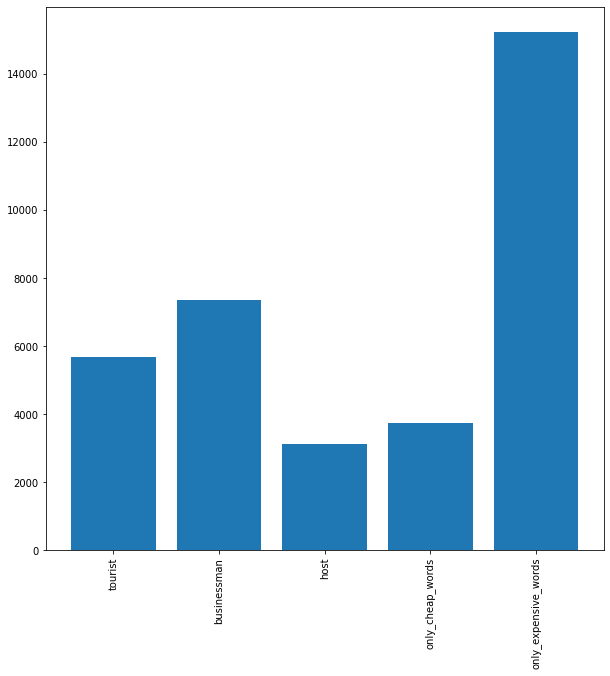

In [107]:
bar_plot_features(host_about_features)

# Building a model

Now that we have our features, we can feed them to a model and see how it performs.

Since this is a preliminary investigation, I'll choose three simple regression models from sklearn, fit them with a grid search, and compare their mean squared errors.

First, there are two issues to address from the features we aren't extracting.  The latitude/longitude should probably be normalized, and bathrooms_text needs to be mapped to a float.

In [108]:
def normalize(s):
    return (s - s.mean()) / s.std()

latitude = normalize(listings.latitude)
longitude = normalize(listings.longitude)

To map the bathrooms_text feature, we first look at the values it may take:

In [109]:
listings.bathrooms_text.unique()

array(['1 bath', '2 baths', '1.5 baths', '2.5 baths', nan, '3 baths',
       '3.5 baths', 'Half-bath', '0 baths', '4 baths', '4.5 baths',
       '5 baths', '6 baths', '5.5 baths', '10 baths', '17 baths',
       '11 baths', '7.5 baths', '7 baths', '10.5 baths', '6.5 baths',
       '12 baths', '8 baths', '35 baths', '11.5 baths'], dtype=object)

Our approach will be as straightforward as possible.  If the value is 'nan', we'll just return 1 (we'll assume that they have a bathroom, but just forgot to mention it).  If the value is 'Half-bath', we'll return .5.  Otherwise, we'll parse the float from the beginning of the string.

In [110]:
def map_bathrooms_text(text):
    if text == 'Half-bath':
        return .5
    m = re.match(r'\d*\.\d*', str(text))
    if not m:
        return 1
    return float(m[0])

bathrooms_text = listings.bathrooms_text.apply(map_bathrooms_text)

Now we will define our models

In [137]:
linear_regression = LinearRegression()
decision_tree_regressor = GridSearchCV(DecisionTreeRegressor(), {'max_leaf_nodes': [32,64,128,256]})
linear_svr = GridSearchCV(LinearSVR(), {'C': [.5,1,2]})
mlp_regressor = MLPRegressor((50,100,))
models = [
    linear_regression,
    decision_tree_regressor,
    linear_svr,
    mlp_regressor,
]

Now we split our data for training and validation

In [118]:
X = pd.concat([
    latitude,
    longitude,
    bathrooms_text,
    *amenity_features.values(),
    *description_features.values(), 
    *host_about_features.values(),
], axis=1)

y = listings.price_float

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [138]:
for model in models:
    model.fit(X_train, y_train)

/home/nathan/programming/py/airbnb/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [139]:
errors = []
scores = []
for model in models:
    scores.append(model.score(X_test,y_test))
    errors.append(mean_squared_error(y_test, model.predict(X_test)))

pprint(list(zip(errors,scores)))

[(8993.728799176128, 0.15162099643983484),
 (8636.356223548804, 0.18533197398656842),
 (9606.251720990858, 0.09384167068180826),
 (7933.315380253397, 0.25164986097374265)]


So it appears the mlp_regressor has performed the best out of the four models.  However, the R2 score .251 is still quite low.

# Next Steps

Here I briefly consider what the next steps may be, although I do not pursue them now.

## Feature Engineering

It's quite possible that I've chosen bad features.  I could try adding or removing some from the model, and see if scores improve at all.  I could also try to apply more intensive NLP techniques to get better features from the amenities, description, and about_host features.

## Model Consideration

More complex or advanced models may be appropriate for this data.  Perhaps experimenting with some deeper or more complex neural networks would give better results.  Also, some more control could be taken over the optimization strategies to try and observe the loss functions and see if more rounds of optimization would be appropriate.